In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
import data_creation_pipeline as dcp
import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-07-24 17:12:37.433295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 17:12:37.665664: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 17:12:37.672174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 17:12:41.743639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-24 17:12:47.455414: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [3]:
n_grid = 512
box_size = 1000.

In [4]:
k_min = 0.01
k_max = 0.68
n_bins = 60
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": 128,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': 128,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


In [5]:
args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

args_power_grid_hr = args_power_grid.copy()
args_power_grid_hr['ngrid'] = 512

args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

args_power_grid_hr_interlacing = args_power_grid_hr.copy()
args_power_grid_hr_interlacing['interlacing'] = True

In [6]:
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Muchisimocks

In [54]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

tag_params = '_p3_n500'
tag_mocks = f'{tag_params}'
tag_fields = '_deconvolved'
dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[0,0,0,0]'
tag_pk = '_b0000'
tag_pk_zspace = '_b0000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

# idxs_LH = np.sort([int(re.search(r'LH(\d+)', dir_mocks).group(1)) \
#         for dir_mocks in os.listdir(dir_mocks) \
#         if re.search(r'LH\d+', dir_mocks)])
# idxs_LH = np.sort([int(re.search(r'_(\d+)', dir_pks_zspace).group(1)) \
#         for dir_pks_zspace in os.listdir(dir_pks_zspace) \
#         if re.search(r'_\d+', dir_pks_zspace)])

#idxs_LH = np.arange(100)
idxs_LH = np.arange(1)
n = len(idxs_LH)
print(idxs_LH)
print(n)

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()


[0]
1


In [55]:
tag_mocks_fixdamp = f'{tag_params}_fixdamp'
dir_mocks_fixdamp = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks_fixdamp}'

In [56]:
tag_mocks_fixdamp1 = f'{tag_params}_fixdamp0.1'
dir_mocks_fixdamp1 = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks_fixdamp1}'

In [57]:
print(dir_mocks)
print(dir_mocks_fixdamp)
print(dir_mocks_fixdamp1)

/cosmos_storage/cosmosims/muchisimocks_lib_p3_n500
/cosmos_storage/cosmosims/muchisimocks_lib_p3_n500_fixdamp
/cosmos_storage/cosmosims/muchisimocks_lib_p3_n500_fixdamp0.1


In [58]:
idx_LH = idxs_LH[0]
param_dict = params_df.loc[idx_LH].to_dict()
param_dict.update(param_dict_fixed)
print(param_dict)
cosmo = utils.get_cosmo(param_dict)


{'omega_cold': 0.2354364478472455, 'sigma8_cold': 0.7321856249065307, 'hubble': 0.6440757656307619, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}
Param tau not in param dict, adding quijote value


In [59]:
bias_params

array([0., 0., 0., 0.])

In [60]:
tag_fields = ''
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_nodeconv = np.load(fn_fields)
print(bias_terms_eul_nodeconv.shape)
print(bias_terms_eul_nodeconv.dtype)

(5, 128, 128, 128)
float32


In [61]:

tag_fields = '_deconvolved'
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)
print(bias_terms_eul.shape)

tag_fields_zspace = '_zspace_deconvolved'
fn_fields_zspace = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields_zspace}_{idx_LH}.npy'
bias_terms_eul_zspace = np.load(fn_fields_zspace)
print(bias_terms_eul_zspace.shape)

tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)
tracer_field_zspace = utils.get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)

(5, 128, 128, 128)
(5, 128, 128, 128)


In [62]:
tag_fields = ''
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_nodeconv = np.load(fn_fields)

tag_fields = '_hr'
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_hr_nodeconv = np.load(fn_fields)

tag_fields = '_zspace'
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_zspace_nodeconv = np.load(fn_fields)

tag_fields_zspace = '_zspace_hr'
fn_fields_zspace = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields_zspace}_{idx_LH}.npy'
bias_terms_eul_zspace_hr_nodeconv = np.load(fn_fields_zspace)

tracer_field_nodeconv = utils.get_tracer_field(bias_terms_eul_nodeconv, bias_params, n_grid_norm=n_grid_orig)
tracer_field_hr_nodeconv = utils.get_tracer_field(bias_terms_eul_hr_nodeconv, bias_params, n_grid_norm=n_grid_orig)
tracer_field_zspace_nodeconv = utils.get_tracer_field(bias_terms_eul_zspace_nodeconv, bias_params, n_grid_norm=n_grid_orig)
tracer_field_zspace_hr_nodeconv = utils.get_tracer_field(bias_terms_eul_zspace_hr_nodeconv, bias_params, n_grid_norm=n_grid_orig)

In [63]:
tag_fields = '_deconvolved'
fn_fields_fixdamp = f'{dir_mocks_fixdamp}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_fixdamp = np.load(fn_fields_fixdamp)

tag_fields = '_hr'
fn_fields_fixdamp = f'{dir_mocks_fixdamp}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_hr_nodeconv_fixdamp = np.load(fn_fields_fixdamp)

tracer_field_fixdamp = utils.get_tracer_field(bias_terms_eul_fixdamp, bias_params, n_grid_norm=n_grid_orig)
tracer_field_hr_nodeconv_fixdamp = utils.get_tracer_field(bias_terms_eul_hr_nodeconv_fixdamp, 
                                                          bias_params, n_grid_norm=n_grid_orig)

In [64]:
tag_fields_zspace = '_zspace_deconvolved'
fn_fields_zspace_fixdamp = f'{dir_mocks_fixdamp}/LH{idx_LH}/bias_fields_eul{tag_fields_zspace}_{idx_LH}.npy'
bias_terms_eul_zspace_fixdamp = np.load(fn_fields_zspace_fixdamp)

tag_fields_zspace = '_zspace_hr'
fn_fields_zspace_fixdamp = f'{dir_mocks_fixdamp}/LH{idx_LH}/bias_fields_eul{tag_fields_zspace}_{idx_LH}.npy'
bias_terms_eul_zspace_hr_nodeconv_fixdamp = np.load(fn_fields_zspace_fixdamp)

tracer_field_zspace_fixdamp = utils.get_tracer_field(bias_terms_eul_zspace_fixdamp, bias_params, n_grid_norm=n_grid_orig)
tracer_field_zspace_hr_nodeconv_fixdamp = utils.get_tracer_field(bias_terms_eul_zspace_hr_nodeconv_fixdamp, bias_params, n_grid_norm=n_grid_orig)

In [65]:
tag_fields = '_deconvolved'
fn_fields_fixdamp1 = f'{dir_mocks_fixdamp1}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_fixdamp1 = np.load(fn_fields_fixdamp1)

tag_fields = '_hr'
fn_fields_fixdamp1 = f'{dir_mocks_fixdamp1}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_hr_nodeconv_fixdamp1 = np.load(fn_fields_fixdamp1)

tracer_field_fixdamp1 = utils.get_tracer_field(bias_terms_eul_fixdamp1, bias_params, n_grid_norm=n_grid_orig)
tracer_field_hr_nodeconv_fixdamp1 = utils.get_tracer_field(bias_terms_eul_hr_nodeconv_fixdamp1, 
                                                          bias_params, n_grid_norm=n_grid_orig)

In [66]:
bias_terms_eul_hr = dcp.deconvolve_bias_field(bias_terms_eul_hr_nodeconv, n_grid_orig)
# for some reason this pb function turns our float32 array into float64, 
# convert back before saving
bias_terms_eul_hr = bias_terms_eul_hr.astype(np.float32)

In [77]:
tracer_field_hr = utils.get_tracer_field(bias_terms_eul_hr, bias_params, n_grid_norm=n_grid_orig)

In [67]:
pk_obj = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    cosmology=cosmo,
                    **args_power_grid_deconvolveFalse)

2024-07-24 18:03:31,776 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007049 sec
bacco.power : Counting modes


2024-07-24 18:03:32,658 bacco.statistics :  ...done in 0.882 s


bacco.power : done counting modes in 0.196023 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000729 secs
bacco.power : Deallocating arrays


In [68]:
pk_obj_hr_pkdeconv = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr_nodeconv,
                    grid2=tracer_field_hr_nodeconv,
                    cosmology=cosmo,
                    **args_power_grid_hr)

2024-07-24 18:03:34,993 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.414666 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.685509 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000467 secs
bacco.power : Deallocating arrays


2024-07-24 18:03:42,900 bacco.statistics :  ...done in 7.91 s


In [69]:
pk_obj_fixdamp = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_fixdamp,
                    grid2=tracer_field_fixdamp,
                    cosmology=cosmo,
                    **args_power_grid_deconvolveFalse)

2024-07-24 18:03:45,378 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-24 18:03:45,557 bacco.statistics :  ...done in 0.18 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010433 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.087336 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000354 secs
bacco.power : Deallocating arrays


In [70]:
pk_obj_hr_pkdeconv_fixdamp = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr_nodeconv_fixdamp,
                    grid2=tracer_field_hr_nodeconv_fixdamp,
                    cosmology=cosmo,
                    **args_power_grid_hr)

2024-07-24 18:03:47,897 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.435321 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.758062 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.001087 secs
bacco.power : Deallocating arrays


2024-07-24 18:03:56,338 bacco.statistics :  ...done in 8.44 s


In [71]:
pk_obj_fixdamp1 = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_fixdamp1,
                    grid2=tracer_field_fixdamp1,
                    cosmology=cosmo,
                    **args_power_grid_deconvolveFalse)

2024-07-24 18:03:58,442 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-24 18:03:58,641 bacco.statistics :  ...done in 0.2 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.022140 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.086170 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000471 secs
bacco.power : Deallocating arrays


In [72]:
pk_obj_hr_pkdeconv_fixdamp1 = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr_nodeconv_fixdamp1,
                    grid2=tracer_field_hr_nodeconv_fixdamp1,
                    cosmology=cosmo,
                    **args_power_grid_hr)

2024-07-24 18:04:00,859 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.340949 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.585462 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000423 secs
bacco.power : Deallocating arrays


2024-07-24 18:04:09,143 bacco.statistics :  ...done in 8.28 s


In [73]:
pk_obj_zspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_zspace,
                    grid2=tracer_field_zspace,
                    cosmology=cosmo,
                    **args_power_grid_deconvolveFalse)

2024-07-24 18:04:10,671 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-24 18:04:10,865 bacco.statistics :  ...done in 0.194 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.020354 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.087506 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000500 secs
bacco.power : Deallocating arrays


In [74]:
pk_obj_zspace_fixdamp = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_zspace_fixdamp,
                    grid2=tracer_field_zspace_fixdamp,
                    cosmology=cosmo,
                    **args_power_grid_deconvolveFalse)

2024-07-24 18:04:12,709 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-24 18:04:12,858 bacco.statistics :  ...done in 0.149 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.006141 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.065065 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000386 secs
bacco.power : Deallocating arrays


In [78]:
pk_obj_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    cosmology=cosmo,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-24 18:06:53,102 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.043810 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.824978 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000528 secs
bacco.power : Deallocating arrays


2024-07-24 18:07:01,274 bacco.statistics :  ...done in 8.17 s


In [79]:
pk_obj_nodeconv = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_nodeconv,
                    grid2=tracer_field_nodeconv,
                    cosmology=cosmo,
                    **args_power_grid_deconvolveFalse)

2024-07-24 18:07:04,717 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-24 18:07:04,935 bacco.statistics :  ...done in 0.218 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.006847 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.098825 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000371 secs
bacco.power : Deallocating arrays


In [80]:
pk_obj_hr_nodeconv = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr_nodeconv,
                    grid2=tracer_field_hr_nodeconv,
                    cosmology=cosmo,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-24 18:07:07,697 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.345617 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.630111 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000791 secs
bacco.power : Deallocating arrays


2024-07-24 18:07:15,827 bacco.statistics :  ...done in 8.13 s


In [81]:
pk_obj_zspace_hr_fixdamp = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_zspace_hr_nodeconv_fixdamp,
                    grid2=tracer_field_zspace_hr_nodeconv_fixdamp,
                    cosmology=cosmo,
                    **args_power_grid_hr)

2024-07-24 18:07:17,800 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.120752 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.199733 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000712 secs
bacco.power : Deallocating arrays


2024-07-24 18:07:27,820 bacco.statistics :  ...done in 10.0 s


In [82]:
kk = pk_obj['k']
cosmo_params_emu = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo)
_, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu)

In [83]:
pk_emu = pk_model_unscaled

/tmp/ipykernel_258140/917151439.py:74: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_258140/917151439.py:75: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


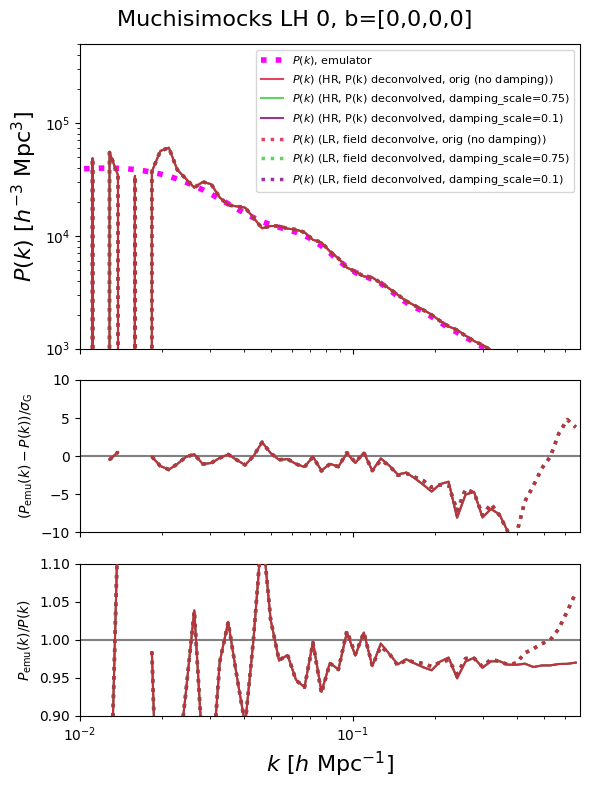

In [84]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          #r'$P(k)$ (HR, no deconvolution)',
          #r'$P(k)$ (HR, field deconvolved)',
          r'$P(k)$ (HR, P(k) deconvolved, orig (no damping))',
          r'$P(k)$ (HR, P(k) deconvolved, damping_scale=0.75)',
          r'$P(k)$ (HR, P(k) deconvolved, damping_scale=0.1)',
          #r'$P(k)$ (LR, no deconvolution)',
          r'$P(k)$ (LR, field deconvolve, orig (no damping))',
          r'$P(k)$ (LR, field deconvolved, damping_scale=0.75)',
          r'$P(k)$ (LR, field deconvolved, damping_scale=0.1)',

          #r'$P(k)$ (LR, field deconvolved, via lib, z-space)',
          #r'$P(k)$ (HR, P(k) deconvolved, via lib, z-space)',
          #r'$P(k)$ (LR, field deconvolved, via lib, p(k) in z-space)',
          ]
colors = ['crimson', 'limegreen', 'purple', 
          'crimson', 'limegreen', 'purple', 
          'orange']
lss = ['-', '-', '-',
       ':', ':', ':', '-.']
lws = [1.5, 1.5, 1.5,
       2.5, 2.5, 2.5, 2.5]
pk_objs = [
           #pk_obj_hr_nodeconv,
           #pk_obj_hr,
           pk_obj_hr_pkdeconv,
           pk_obj_hr_pkdeconv_fixdamp,
           pk_obj_hr_pkdeconv_fixdamp1,
           #pk_obj_nodeconv,
           pk_obj,
           pk_obj_fixdamp,
           pk_obj_fixdamp1,
           #pk_obj_tozspace,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH}{title_tag}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='upper right')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

/tmp/ipykernel_258140/1852038511.py:68: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_258140/1852038511.py:69: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


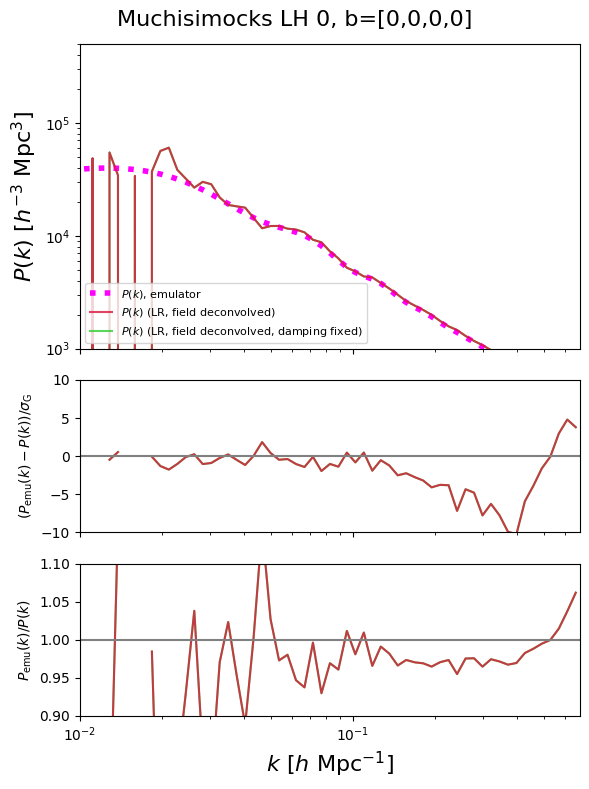

In [85]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          #r'$P(k)$ (HR, no deconvolution)',
          #r'$P(k)$ (HR, field deconvolved)',
          #r'$P(k)$ (HR, P(k) deconvolved)',
          #r'$P(k)$ (LR, no deconvolution)',
          r'$P(k)$ (LR, field deconvolved)',
          r'$P(k)$ (LR, field deconvolved, damping fixed)',

          #r'$P(k)$ (LR, field deconvolved, via lib, z-space)',
          #r'$P(k)$ (HR, P(k) deconvolved, via lib, z-space)',
          #r'$P(k)$ (LR, field deconvolved, via lib, p(k) in z-space)',
          ]
colors = ['crimson', 'limegreen', 'purple', 
          'crimson', 'limegreen', 'purple', 
          'orange']
lss = ['-', '-', '-',
       ':', ':', ':', '-.']
lws = [1.5, 1.5, 3,
       2.5, 2.5, 1.5, 2.5]
pk_objs = [
           #pk_obj_hr_nodeconv,
           #pk_obj_hr,
           #pk_obj_hr_pkdeconv,
           #pk_obj_nodeconv,
           pk_obj,
           pk_obj_fixdamp,
           #pk_obj_tozspace,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH}{title_tag}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

#### z-space

In [86]:
expfactor = 1.0
b1_lag = bias_params[0]
b1_eul = 1.0 + b1_lag
kaiser_boost_mm = cosmo.Kaiser_boost(expfactor, l=0, bias=b1_eul)
print(kaiser_boost_mm)

1.3379059822851023


/tmp/ipykernel_258140/1210055342.py:37: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (pk_kaiserboosted-pk_zspace)/pk_zspace, ls='--', alpha=alpha, color=color_real, lw=lw)
/tmp/ipykernel_258140/1210055342.py:38: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (pk_hr_kaiserboosted-pk_hr_zspace)/pk_hr_zspace, ls='-', alpha=alpha, color=color_real, lw=lw)
/tmp/ipykernel_258140/1210055342.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (pk_emu_kaiserboosted-pk_zspace)/pk_zspace, ls='--', alpha=alpha, color=color_zspace, lw=lw)
/tmp/ipykernel_258140/1210055342.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (pk_emu_kaiserboosted-pk_hr_zspace)/pk_hr_zspace, ls='-', alpha=alpha, color=color_zspace, lw=lw)


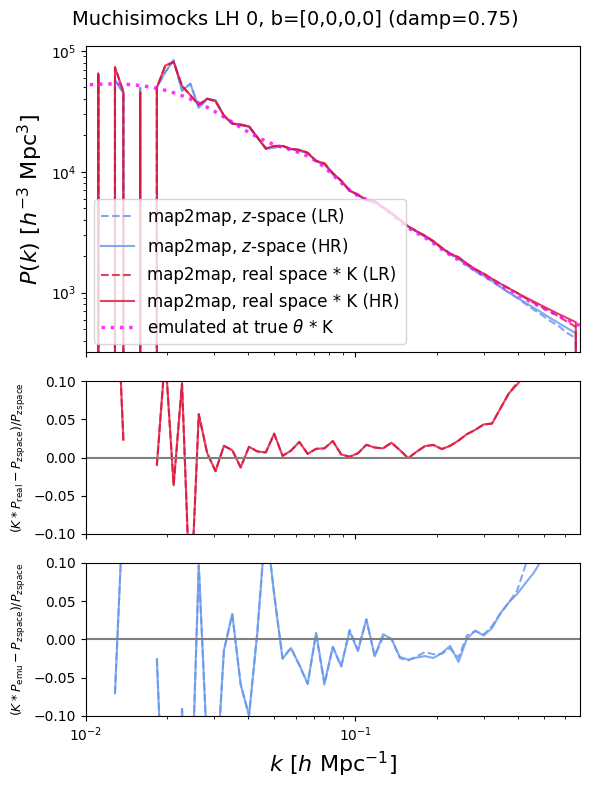

In [87]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

plt.suptitle(f'Muchisimocks LH {idx_LH}{title_tag} (damp=0.75)', fontsize=14)

first = True
label_true, label_emu, label_stdev = None, None, None
if first:
       label_emu = r'emulated at true $\theta$ * K'
       label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
       label_real_kb = 'map2map, real space * K'
       label_zspace = r'map2map, $z$-space'
            
pk_emu_kaiserboosted = kaiser_boost_mm*pk_emu

pk_kaiserboosted = kaiser_boost_mm*pk_obj_fixdamp['pk']
pk_zspace = pk_obj_zspace_fixdamp['pk']
pk_hr_kaiserboosted = kaiser_boost_mm*pk_obj_hr_pkdeconv_fixdamp['pk']
pk_hr_zspace = pk_obj_zspace_hr_fixdamp ['pk']

color_zspace = 'cornflowerblue'
color_real = 'crimson'

k = kk

lw=1.5
axarr[0].plot(k, pk_zspace, ls='--', alpha=alpha, label=label_zspace+' (LR)', color=color_zspace, lw=lw)
axarr[0].plot(k, pk_hr_zspace, ls='-', alpha=alpha, label=label_zspace+' (HR)', color=color_zspace, lw=lw)
axarr[0].plot(k, pk_kaiserboosted, ls='--', markersize=3, alpha=alpha, label=label_real_kb+' (LR)', color=color_real)
axarr[0].plot(k, pk_hr_kaiserboosted, ls='-', markersize=3, alpha=alpha, label=label_real_kb+' (HR)', color=color_real)
axarr[0].plot(k, pk_emu_kaiserboosted, ls=':', alpha=alpha, label=label_emu, color='magenta', lw=2.5)

#axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
axarr[1].plot(k, (pk_kaiserboosted-pk_zspace)/pk_zspace, ls='--', alpha=alpha, color=color_real, lw=lw)
axarr[1].plot(k, (pk_hr_kaiserboosted-pk_hr_zspace)/pk_hr_zspace, ls='-', alpha=alpha, color=color_real, lw=lw)
axarr[2].plot(k, (pk_emu_kaiserboosted-pk_zspace)/pk_zspace, ls='--', alpha=alpha, color=color_zspace, lw=lw)
axarr[2].plot(k, (pk_emu_kaiserboosted-pk_hr_zspace)/pk_hr_zspace, ls='-', alpha=alpha, color=color_zspace, lw=lw)


ax1.axhline(0.0, color='grey')
ax2.axhline(0.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
#ax1.set_ylim(-10, 10)
#ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

# Quijote 0663

In [81]:
idx_LH_str = '0663' # quijote LH idx to test
dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

n_grid = 512
n_grid_orig = 512
box_size = 1000.0

In [82]:
fn_params = f'{dir_data}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names, param_vals))
cosmo_quijote = utils.get_cosmo(param_dict)
cosmo_params_emu_quijote = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote)

Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value


In [83]:
print(param_dict)
print(cosmo_quijote.pars)
print(cosmo_params_emu_quijote)

{'omega_m': 0.3223, 'omega_baryon': 0.04625, 'h': 0.7015, 'n_s': 0.9607, 'sigma_8': 0.8311}
{'hubble': 0.7015, 'sigma8': 0.8311, 'A_s': None, 'omega_baryon': 0.04625, 'omega_cdm': 0.27604999999999996, 'w0': -1.0, 'wa': 0.0, 'ns': 0.9607, 'tau': 0.0561, 'approx_nu': False, 'num_massive_neutrinos': 0, 'neutrino_mass': 0.0, 'Neffective': 3.046, 'DeltaNeff': 3.046, 'GammaNu': 0.71611, 'omega_neutrino': 0.0, 'omega_matter': 0.3223, 'omega_cold': 0.3223, 'photon_temperature': 2.7255, 'omega_photons': 0.0, 'omega_rad': 0.0, 'omega_de': 0.6777, 'omega_k': 0.0, 'omega_tot': 1.0}
{'sigma8_cold': 0.8311, 'omega_cold': 0.3223, 'hubble': 0.7015, 'ns': 0.9607, 'omega_baryon': 0.04625, 'expfactor': 1, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}


In [84]:
tag_fields = '_interlacingfalse'
dir_fields = f'/cosmos_storage/home/kstoreyf/data_muchisimocks/quijote_LH{tag_fields}'
tag_fields_interlacing = ''
dir_fields_interlacing = f'/cosmos_storage/home/kstoreyf/data_muchisimocks/quijote_LH{tag_fields_interlacing}'

In [85]:
tag = '_sim'
fn_fields = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields{tag}_{idx_LH_str}.npy'
fn_fields_zspace = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields_zspace{tag}_{idx_LH_str}.npy'
bias_terms_eul_sim = np.load(fn_fields, allow_pickle=True)
bias_terms_eul_zspace_sim = np.load(fn_fields_zspace, allow_pickle=True)

In [86]:
tag = '_pred'
fn_fields = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields{tag}_{idx_LH_str}.npy'
fn_fields_zspace = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields_zspace{tag}_{idx_LH_str}.npy'
bias_terms_eul = np.load(fn_fields, allow_pickle=True)
bias_terms_eul_zspace = np.load(fn_fields_zspace, allow_pickle=True)

In [87]:
bias_params = [1,0,0,0]
title_tag = ', b=[1,0,0,0]'

tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)
tracer_field_sim = utils.get_tracer_field(bias_terms_eul_sim, bias_params, n_grid_norm=n_grid_orig)

tracer_field_zspace = utils.get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)
tracer_field_zspace_sim = utils.get_tracer_field(bias_terms_eul_zspace_sim, bias_params, n_grid_norm=n_grid_orig)

interlacing

In [89]:
tag = '_sim'
fn_fields_interlacing = f'{dir_fields_interlacing}/LH{idx_LH_str}/Eulerian_fields{tag}_{idx_LH_str}.npy'
fn_fields_zspace_interlacing = f'{dir_fields_interlacing}/LH{idx_LH_str}/Eulerian_fields_zspace{tag}_{idx_LH_str}.npy'
bias_terms_eul_sim_interlacing = np.load(fn_fields_interlacing, allow_pickle=True)
bias_terms_eul_zspace_sim_interlacing = np.load(fn_fields_zspace_interlacing, allow_pickle=True)

In [90]:
tag = '_pred'
fn_fields_interlacing = f'{dir_fields_interlacing}/LH{idx_LH_str}/Eulerian_fields{tag}_{idx_LH_str}.npy'
#fn_fields_zspace = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields_zspace{tag}_{idx_LH_str}.npy'
bias_terms_eul_interlacing = np.load(fn_fields_interlacing, allow_pickle=True)
#bias_terms_eul_zspace = np.load(fn_fields_zspace, allow_pickle=True)

In [91]:
tracer_field_interlacing = utils.get_tracer_field(bias_terms_eul_interlacing, bias_params, n_grid_norm=n_grid_orig)
tracer_field_sim_interlacing = utils.get_tracer_field(bias_terms_eul_sim_interlacing, bias_params, n_grid_norm=n_grid_orig)

#tracer_field_zspace = utils.get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)
tracer_field_zspace_sim_interlacing = utils.get_tracer_field(bias_terms_eul_zspace_sim_interlacing, bias_params, n_grid_norm=n_grid_orig)

In [92]:
pk_obj_sim = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_sim,
                    grid2=tracer_field_sim,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr)

2024-07-24 10:57:09,142 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.415364 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.505766 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000414 secs
bacco.power : Deallocating arrays


2024-07-24 10:57:19,504 bacco.statistics :  ...done in 10.4 s


In [93]:
pk_obj = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr)

2024-07-24 10:57:21,104 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.136182 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.574610 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000247 secs
bacco.power : Deallocating arrays


2024-07-24 10:57:30,947 bacco.statistics :  ...done in 9.84 s


In [94]:
pk_obj_sim_interlacing = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_sim_interlacing,
                    grid2=tracer_field_sim_interlacing,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr_interlacing)

2024-07-24 10:57:32,683 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.198141 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.640403 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000145 secs
bacco.power : Deallocating arrays


2024-07-24 10:57:49,952 bacco.statistics :  ...done in 17.3 s


In [95]:
pk_obj_interlacing = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_interlacing,
                    grid2=tracer_field_interlacing,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr_interlacing)

2024-07-24 10:57:51,544 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.191459 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.644237 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-07-24 10:58:09,465 bacco.statistics :  ...done in 17.9 s


In [96]:
pk_obj_sim_zspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_zspace_sim,
                    grid2=tracer_field_zspace_sim,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr)

2024-07-24 10:58:11,047 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.234187 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.490438 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


2024-07-24 10:58:19,951 bacco.statistics :  ...done in 8.9 s


In [97]:
pk_obj_zspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_zspace,
                    grid2=tracer_field_zspace,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr)

2024-07-24 10:58:21,351 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.298351 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.487772 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-07-24 10:58:30,430 bacco.statistics :  ...done in 9.08 s


In [98]:
cosmo_params_emu_quijote

{'sigma8_cold': 0.8311,
 'omega_cold': 0.3223,
 'hubble': 0.7015,
 'ns': 0.9607,
 'omega_baryon': 0.04625,
 'expfactor': 1,
 'neutrino_mass': 0.0,
 'w0': -1.0,
 'wa': 0.0}

In [99]:
kk = pk_obj['k']
_, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu_quijote)
pk_emu = pk_model_unscaled

/tmp/ipykernel_56338/155260724.py:54: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_56338/155260724.py:55: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


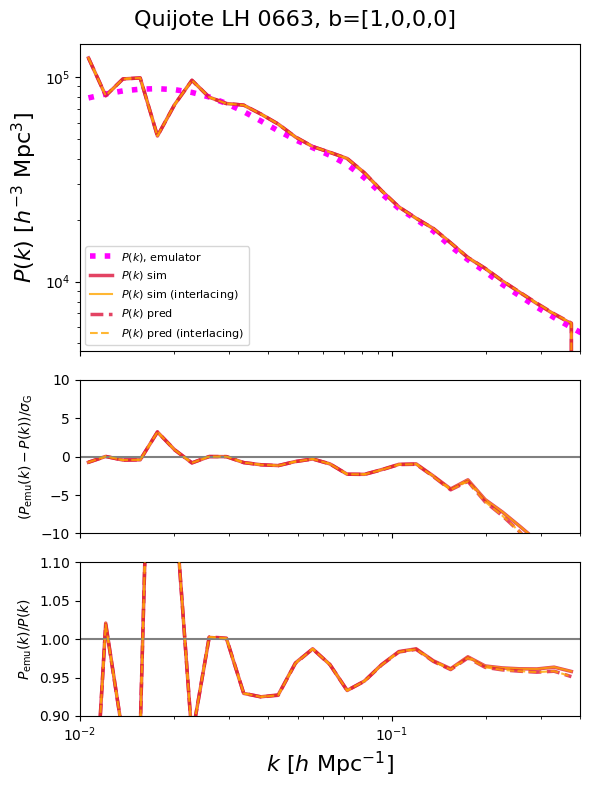

In [100]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ sim',
          r'$P(k)$ sim (interlacing)',
          r'$P(k)$ pred',
          r'$P(k)$ pred (interlacing)',
          ]
colors = ['crimson', 'orange', #'purple', 
          'crimson', 'orange', #'purple', 
          'orange']
lss = ['-', '-',
       '--', '--']
lws = [2.5, 1.5,
       2.5, 1.5]
pk_objs = [pk_obj_sim,
           pk_obj_sim_interlacing,
           pk_obj,
           pk_obj_interlacing,
           ]
#zorders = list(range(len(pk_objs),0,-1))
zorders = list(range(len(pk_objs)))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Quijote LH {idx_LH_str}{title_tag}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [104]:
# expfactor = 1.0
# kaiser_boost =cosmo_quijote.Kaiser_boost(expfactor, l=0, bias=bias_params[0])
# print(kaiser_boost)

In [105]:
expfactor = 1.0
b1_lag = bias_params[0]
b1_eul = 1.0 + b1_lag
kaiser_boost = cosmo_quijote.Kaiser_boost(expfactor, l=0, bias=b1_eul)
print(kaiser_boost)

1.1922238496480468


/tmp/ipykernel_56338/2067975523.py:42: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (pk_kaiserboosted-pk_zspace)/pk_zspace, ls='-', alpha=alpha, color=color_real, lw=lw)
/tmp/ipykernel_56338/2067975523.py:43: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (pk_emu_kaiserboosted-pk_zspace)/pk_zspace, ls=':', alpha=alpha, color='magenta', lw=lw)


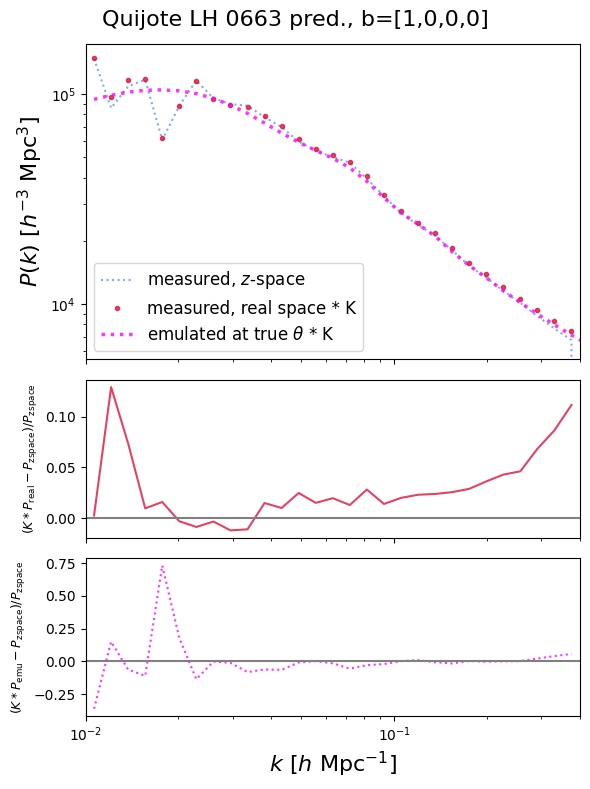

In [106]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

plt.suptitle(f'Quijote LH {idx_LH_str} pred.{title_tag}', fontsize=16)

first = True
label_true, label_emu, label_stdev = None, None, None
if first:
       label_true = 'map2map measured'
       label_emu = r'emulated at true $\theta$ * K'
       label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
       label_real_kb = 'measured, real space * K'
       label_zspace = r'measured, $z$-space'
            
pk_emu_kaiserboosted = kaiser_boost*pk_emu
# ax.loglog(kk, pk_emu_kaiserboosted, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

# pk = factors[i]*pks[i]
# ax.loglog(ks[i], pk, ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])

# ax1.plot(ks[i], (pk_emu_kaiserboosted-pk)/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
# ax2.plot(ks[i], (pk_emu_kaiserboosted/pk), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])

pk_kaiserboosted = kaiser_boost*pk_obj['pk']
pk_zspace = pk_obj_zspace['pk']

color_zspace = 'cornflowerblue'
color_real = 'crimson'

k = kk

lw=1.5
axarr[0].plot(k, pk_zspace, ls=':', alpha=alpha, label=label_zspace, color=color_zspace, lw=lw)

axarr[0].plot(k, pk_kaiserboosted, ls='None', marker='o', markersize=3, alpha=alpha, label=label_real_kb, color=color_real)
axarr[0].plot(k, pk_emu_kaiserboosted, ls=':', alpha=alpha, label=label_emu, color='magenta', lw=2.5)

#axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
axarr[1].plot(k, (pk_kaiserboosted-pk_zspace)/pk_zspace, ls='-', alpha=alpha, color=color_real, lw=lw)
axarr[2].plot(k, (pk_emu_kaiserboosted-pk_zspace)/pk_zspace, ls=':', alpha=alpha, color='magenta', lw=lw)


ax1.axhline(0.0, color='grey')
ax2.axhline(0.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

#ax1.set_ylim(-10, 10)
#ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

/tmp/ipykernel_56338/3462244080.py:40: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (pk_kaiserboosted-pk_zspace)/pk_zspace, ls='-', alpha=alpha, color=color_real, lw=lw)
/tmp/ipykernel_56338/3462244080.py:41: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (pk_emu_kaiserboosted-pk_zspace)/pk_zspace, ls=':', alpha=alpha, color='magenta', lw=lw)


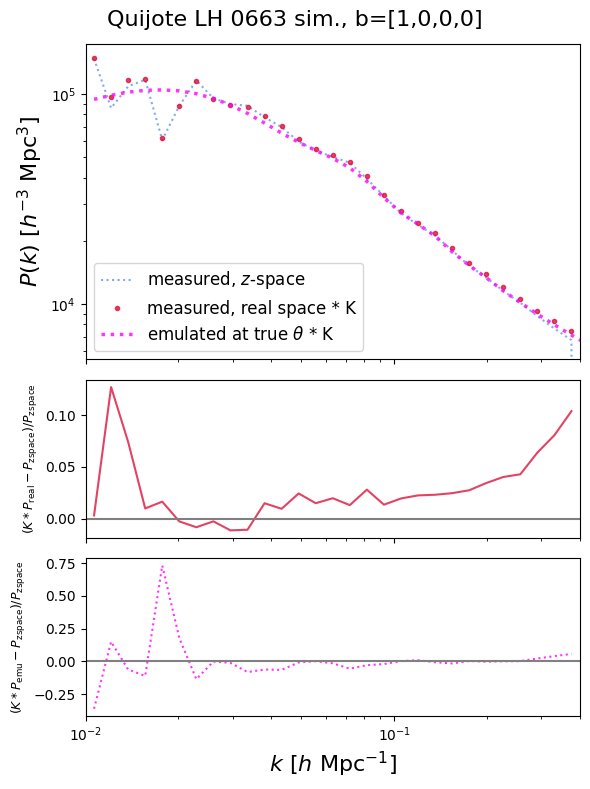

In [107]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

plt.suptitle(f'Quijote LH {idx_LH_str} sim.{title_tag}', fontsize=16)

first = True
label_true, label_emu, label_stdev = None, None, None
if first:
       label_true = 'map2map measured'
       label_emu = r'emulated at true $\theta$ * K'
       label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
       label_real_kb = 'measured, real space * K'
       label_zspace = r'measured, $z$-space'
            
pk_emu_kaiserboosted = kaiser_boost*pk_emu
# ax.loglog(kk, pk_emu_kaiserboosted, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

# pk = factors[i]*pks[i]
# ax.loglog(ks[i], pk, ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])

# ax1.plot(ks[i], (pk_emu_kaiserboosted-pk)/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
# ax2.plot(ks[i], (pk_emu_kaiserboosted/pk), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])

pk_kaiserboosted = kaiser_boost*pk_obj_sim['pk']
pk_zspace = pk_obj_sim_zspace['pk']

color_zspace = 'cornflowerblue'
color_real = 'crimson'

k = kk
axarr[0].plot(k, pk_zspace, ls=':', alpha=alpha, label=label_zspace, color=color_zspace, lw=lw)

axarr[0].plot(k, pk_kaiserboosted, ls='None', marker='o', markersize=3, alpha=alpha, label=label_real_kb, color=color_real)
axarr[0].plot(k, pk_emu_kaiserboosted, ls=':', alpha=alpha, label=label_emu, color='magenta', lw=2.5)

#axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
axarr[1].plot(k, (pk_kaiserboosted-pk_zspace)/pk_zspace, ls='-', alpha=alpha, color=color_real, lw=lw)
axarr[2].plot(k, (pk_emu_kaiserboosted-pk_zspace)/pk_zspace, ls=':', alpha=alpha, color='magenta', lw=lw)


ax1.axhline(0.0, color='grey')
ax2.axhline(0.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

#ax1.set_ylim(-10, 10)
#ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

/tmp/ipykernel_56338/2403821206.py:61: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu_kaiserboosted-pk)/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_56338/2403821206.py:62: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu_kaiserboosted/pk), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


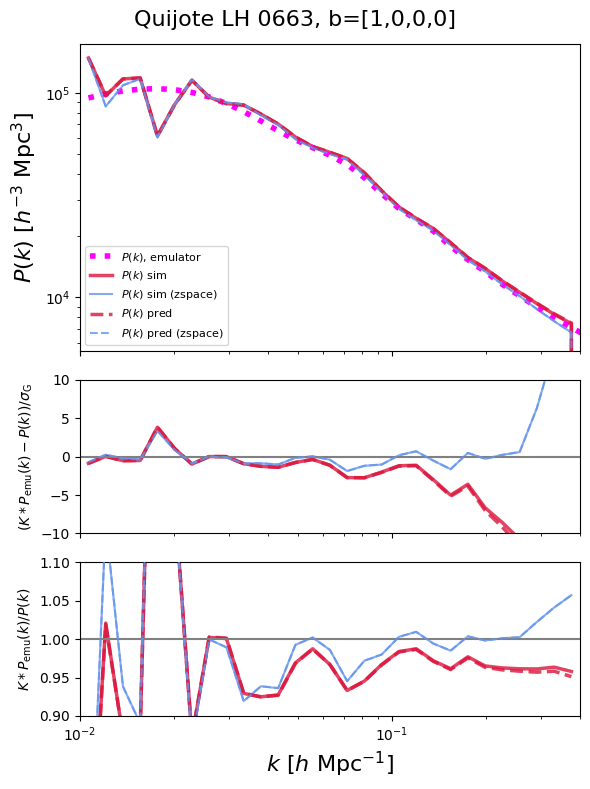

: 

In [108]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ sim',
          r'$P(k)$ sim (zspace)',
          r'$P(k)$ pred',
          r'$P(k)$ pred (zspace)',
          ]
colors = ['crimson', 'cornflowerblue', #'purple', 
          'crimson', 'cornflowerblue', #'purple', 
          'orange']
lss = ['-', '-',
       '--', '--']
lws = [2.5, 1.5,
       2.5, 1.5]
pk_objs = [pk_obj_sim,
           pk_obj_sim_zspace,
           pk_obj,
           pk_obj_zspace,
           ]
factors = [kaiser_boost,
           1.0,
           kaiser_boost,
           1.0]

#zorders = list(range(len(pk_objs),0,-1))
zorders = list(range(len(pk_objs)))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Quijote LH {idx_LH_str}{title_tag}', fontsize=16)

pk_emu_kaiserboosted = kaiser_boost*pk_emu
ax.loglog(kk, pk_emu_kaiserboosted, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    pk = factors[i]*pks[i]
    ax.loglog(ks[i], pk, ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pk):
        pk_interp = np.interp(kk, ks[i], pk)
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu_kaiserboosted-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu_kaiserboosted/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu_kaiserboosted-pk)/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu_kaiserboosted/pk), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(K*P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$K*P_\text{emu}(k)/P(k)$')
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

# Check individual bias fields

In [36]:
bias_terms_eul_sim_norm = bias_terms_eul_sim/n_grid**3

In [37]:
args_power_grid_hr_normFalse = args_power_grid_hr.copy()
args_power_grid_hr_normFalse['normalise_grid1'] = False
args_power_grid_hr_normFalse['normalise_grid2'] = False

In [38]:
pk_obj_p11 = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=bias_terms_eul_sim_norm[0],
                    grid2=bias_terms_eul_sim_norm[0],
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr_normFalse)

2024-07-19 15:22:32,567 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.006903 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.491210 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000163 secs
bacco.power : Deallocating arrays


2024-07-19 15:22:39,616 bacco.statistics :  ...done in 7.05 s


In [39]:


pk_obj_pdd = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=bias_terms_eul_sim_norm[1],
                    grid2=bias_terms_eul_sim_norm[1],
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr_normFalse)
print(pk_obj_pdd['pk'])

2024-07-19 15:22:41,172 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) -5.39212e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.985804 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.488595 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000407 secs
bacco.power : Deallocating arrays


2024-07-19 15:22:48,509 bacco.statistics :  ...done in 7.34 s


[31800.47489554 20653.35534449 25119.15582486 25334.56480159
 13205.20813156 18843.68295763 24667.76887437 20523.88993523
 19189.71687269 18791.24269353 17111.08911915 15314.08512827
 13277.77463122 12018.9885876  11372.21535573 10664.19680591
  9173.24299737  7603.7420559   6415.98626897  5732.23632567
  5188.86124522  4503.80488739  3899.89439     3533.08696911
  3142.36655094  2832.31868041  2556.56870768  2321.55752276
  2138.46609901     0.        ]


In [40]:
cosmo_params_emu_quijote

{'sigma8_cold': 0.8311,
 'omega_cold': 0.3223,
 'hubble': 0.7015,
 'ns': 0.9607,
 'omega_baryon': 0.04625,
 'expfactor': 1,
 'neutrino_mass': 0.0,
 'w0': -1.0,
 'wa': 0.0}

In [41]:
_, pnn = emu.get_nonlinear_pnn(k=kk, **cosmo_params_emu_quijote)

In [42]:
labels_pnn = ['$1 1$',
 '$1 \\delta$',
 '$1 \\delta^2$',
 '$1 s^2$',
 '$ 1 \\nabla^2\\delta$',
 '$\\delta \\delta$',
 '$\\delta \\delta^2$',
 '$\\delta s^2$',
 '$\\delta \\nabla^2\\delta$',
 '$\\delta^2 \\delta^2$',
 '$\\delta^2 s^2$',
 '$\\delta^2 \\nabla^2\\delta$',
 '$s^2 s^2$',
 '$s^2 \\nabla^2\\delta$',
 '$\\nabla^2\\delta \\nabla^2\\delta$']

/tmp/ipykernel_240139/3307912240.py:19: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (pnn[i_pnn]-pk_obj_p11['pk'])/pk_obj_p11['pk'], ls='-', alpha=alpha, color=color_p11, lw=lw)
/tmp/ipykernel_240139/3307912240.py:24: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (pnn[i_pnn]-pk_obj_pdd['pk'])/pk_obj_p11['pk'], ls='-', alpha=alpha, color=color_pdd, lw=lw)


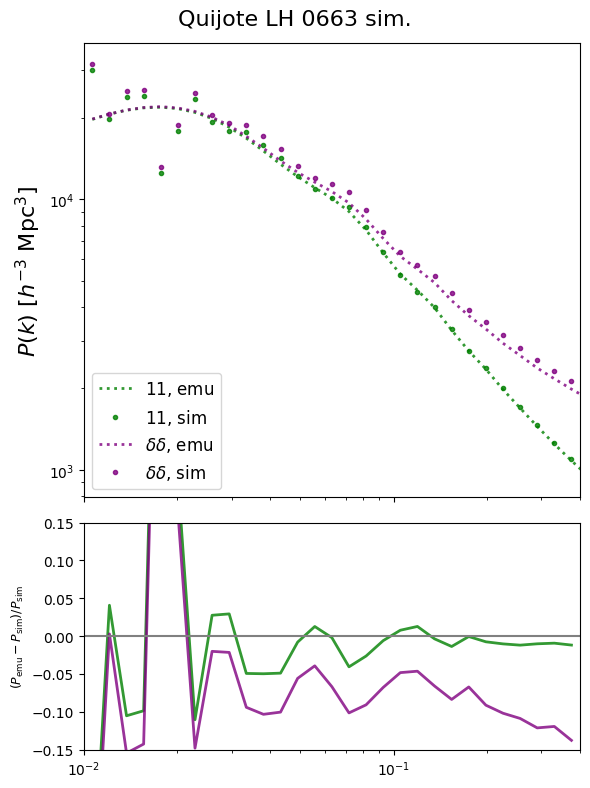

In [43]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

plt.suptitle(f'Quijote LH {idx_LH_str} sim.', fontsize=16)


color_p11 = 'green'
color_pdd = 'purple'

k = kk
lw = 2

i_pnn = 0
axarr[0].plot(k, pnn[i_pnn], ls=':', alpha=alpha, label=f'{labels_pnn[i_pnn]}, emu', color=color_p11, lw=lw)
axarr[0].plot(k, pk_obj_p11['pk'], ls='None', marker='o', markersize=3, alpha=alpha, label=f'{labels_pnn[i_pnn]}, sim', color=color_p11)
axarr[1].plot(k, (pnn[i_pnn]-pk_obj_p11['pk'])/pk_obj_p11['pk'], ls='-', alpha=alpha, color=color_p11, lw=lw)

i_pnn = 5
axarr[0].plot(k, pnn[i_pnn], ls=':', alpha=alpha, label=f'{labels_pnn[i_pnn]}, emu', color=color_pdd, lw=lw)
axarr[0].plot(k, pk_obj_pdd['pk'], ls='None', marker='o', markersize=3, alpha=alpha, label=f'{labels_pnn[i_pnn]}, sim', color=color_pdd)
axarr[1].plot(k, (pnn[i_pnn]-pk_obj_pdd['pk'])/pk_obj_p11['pk'], ls='-', alpha=alpha, color=color_pdd, lw=lw)


ax1.axhline(0.0, color='grey')
ax2.axhline(0.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=9)
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.15, 0.15)
#ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

let's compute all of them

In [44]:
lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid), num=30)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_quijote, expfactor=cosmo_quijote.expfactor, wavemode=lt_k)

In [48]:
np.min(lt_k), np.max(lt_k), len(lt_k)

(0.003141592653589792, 3.216990877275948, 90)

In [49]:
len(pk_lpt), len(pk_lpt[0])

(2, 15)

In [51]:
#Compute the P(k) of the 15 terms
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_sim_norm.shape[0]),r=2)))

In [54]:

power_all_terms_sim = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(prod[ii])
    power_term_sim = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_sim_norm[prod[ii,0]],
                                                    grid2=bias_terms_eul_sim_norm[prod[ii,1]],
                                                    #normalise_grid1=False,
                                                    #normalise_grid2=False,
                                                    #deconvolve_grid1=True,
                                                    #deconvolve_grid2=True,
                                                    cosmology=cosmo_quijote,
                                                    **args_power_grid_hr_normFalse)
    power_all_terms_sim.append(power_term_sim)

2024-07-19 15:34:20,218 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.965883 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.492574 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000164 secs
bacco.power : Deallocating arrays


2024-07-19 15:34:27,616 bacco.statistics :  ...done in 7.4 s
2024-07-19 15:34:27,618 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -5.39212e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.959902 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.485220 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


2024-07-19 15:34:34,619 bacco.statistics :  ...done in 7.0 s
2024-07-19 15:34:34,621 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.40513e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.965658 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.494711 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000159 secs
bacco.power : Deallocating arrays


2024-07-19 15:34:41,605 bacco.statistics :  ...done in 6.98 s
2024-07-19 15:34:41,606 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.970112 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.485425 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


2024-07-19 15:34:48,676 bacco.statistics :  ...done in 7.07 s
2024-07-19 15:34:48,677 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.974575 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.515838 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000163 secs
bacco.power : Deallocating arrays


2024-07-19 15:34:55,724 bacco.statistics :  ...done in 7.05 s
2024-07-19 15:34:55,725 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) -5.39212e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.975267 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.486614 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000166 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:02,708 bacco.statistics :  ...done in 6.98 s
2024-07-19 15:35:02,710 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) 5.40513e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.019441 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.489928 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:09,544 bacco.statistics :  ...done in 6.83 s
2024-07-19 15:35:09,545 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.063698 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.489822 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:16,738 bacco.statistics :  ...done in 7.19 s
2024-07-19 15:35:16,739 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.046865 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.513702 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:23,940 bacco.statistics :  ...done in 7.2 s
2024-07-19 15:35:23,944 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40513e-06 (grid1) 5.40513e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.028028 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.500955 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000158 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:31,149 bacco.statistics :  ...done in 7.2 s
2024-07-19 15:35:31,151 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40513e-06 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.989349 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.485982 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000153 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:38,259 bacco.statistics :  ...done in 7.11 s
2024-07-19 15:35:38,260 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[2 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40513e-06 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.967512 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.510533 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000153 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:45,439 bacco.statistics :  ...done in 7.18 s
2024-07-19 15:35:45,442 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[3 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97816e-06 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.008429 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.495521 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000155 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:52,507 bacco.statistics :  ...done in 7.07 s
2024-07-19 15:35:52,509 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[3 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97816e-06 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.004818 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.490910 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-07-19 15:35:59,282 bacco.statistics :  ...done in 6.77 s
2024-07-19 15:35:59,284 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[4 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.06936e-11 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.964328 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.486899 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000154 secs
bacco.power : Deallocating arrays


2024-07-19 15:36:06,251 bacco.statistics :  ...done in 6.97 s


In [56]:
lt_k_emu = lt_k[lt_k<0.75]
_, pnn = emu.get_nonlinear_pnn(k=lt_k_emu, **cosmo_params_emu_quijote)

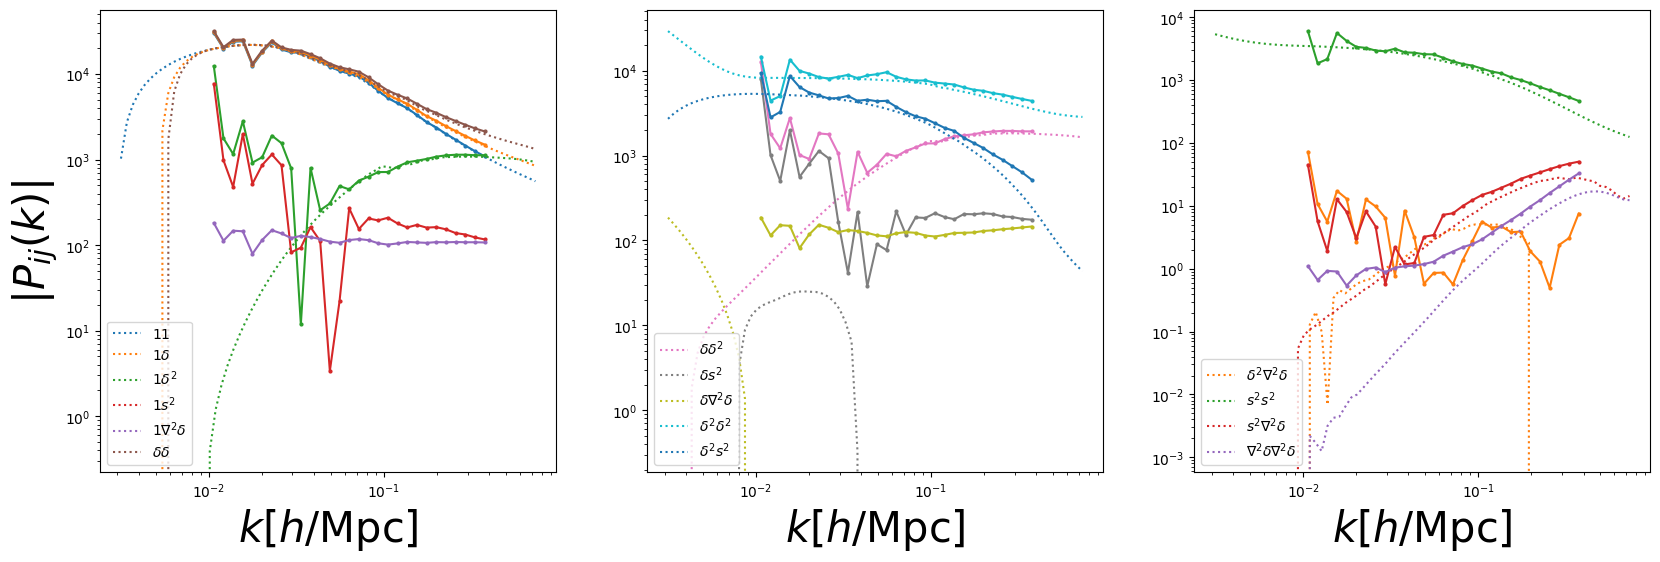

In [62]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

contf=0
for ii in range(len(power_all_terms_sim)):
    mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    # ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_pred[ii]['pk'][mask]),
    #                    color='C'+str(ii), label=labels[ii])
    ax[contf].loglog(power_all_terms_sim[ii]['k'][mask], np.abs(power_all_terms_sim[ii]['pk'][mask]),
                       'o', markersize=2, #ls='None',
                       ls='-',
                       color='C'+str(ii), 
                       #label=f'{labels_pnn[ii]}, sim'
                       )
    ax[contf].loglog(lt_k_emu, pnn[ii], ls=':', color='C'+str(ii), 
                     label=f'{labels_pnn[ii]}')

    ax[contf].legend(loc='lower left', frameon=True, fancybox=True)
    ax[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$ |P_{ij}(k)| $', size=30)
#ax[0].set_ylim(10.,1e5)

plt.show()


# Remake bias fields w diff parameter choices

In [64]:
dir_data

'/cosmos_storage/home/mpelle/Yin_data/Quijote'

In [62]:
fn_dens_lin = f'{dir_data}/LH{idx_LH_str}/lin_den_{idx_LH_str}.npy'
dens_lin = np.load(fn_dens_lin)

# get fields sim
fn_disp = f'{dir_data}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
disp = np.load(fn_disp)

In [65]:
n_grid = 512
damping_scale = 0.75
interlacing = False
bias_terms_eul_damp075 = cpk.displacements_to_bias_fields(dens_lin, disp, n_grid, 
                      box_size, damping_scale=damping_scale, interlacing=interlacing, fn_fields=None)


2024-07-19 11:49:18,767 bacco.BiasModel : Initialising Bias Model class ...
2024-07-19 11:49:20,991 bacco.BiasModel : Computing delta_to_tidal_field with 8 threads...
2024-07-19 11:49:20,992 bacco.BiasModel : fttw plan
2024-07-19 11:49:20,994 bacco.BiasModel : Computing linear field ...
2024-07-19 11:49:20,994 bacco.BiasModel : Memory used: 44.765929472 Gigabytes
2024-07-19 11:49:21,009 bacco.BiasModel : fttw freqs
2024-07-19 11:49:21,010 bacco.BiasModel : tidk freqs
2024-07-19 11:49:28,217 bacco.BiasModel : ifft
2024-07-19 11:50:13,568 bacco.BiasModel : Computing laplacian ...
2024-07-19 11:50:13,570 bacco.BiasModel : Memory used: 49.60243712 Gigabytes
2024-07-19 11:50:15,593 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-19 11:50:15,594 bacco.BiasModel : Memory used: 50.138550272 Gigabytes
2024-07-19 11:50:15,848 bacco.BiasModel : Computing delta squared ...
2024-07-19 11:50:15,851 bacco.BiasModel : Memory used: 50.67532288 Gigabytes
2024-07-19 11:50:17,010 b

bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 11:50:33,881 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 11:50:33,881 bacco.statistics : starting deposit 1
2024-07-19 11:50:36,149 bacco.statistics :  mesh done in 2.27 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 11:50:36,616 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 11:50:36,617 bacco.statistics : starting deposit 1
2024-07-19 11:50:38,923 bacco.statistics :  mesh done in 2.31 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 11:50:39,383 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 11:50:39,384 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-07-19 11:50:41,739 bacco.statistics :  mesh done in 2.36 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 11:50:42,332 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 11:50:42,333 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-07-19 11:50:44,683 bacco.statistics :  mesh done in 2.35 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [96]:
n_grid_n1024 = 1024
damping_scale = 0.75
interlacing = False
bias_terms_eul_sim_damp075_n1024 = cpk.displacements_to_bias_fields(dens_lin, disp, n_grid_n1024, 
                      box_size, damping_scale=damping_scale, interlacing=interlacing, fn_fields=None)


2024-07-19 12:25:24,262 bacco.BiasModel : Initialising Bias Model class ...


n_grid_orig = 512


2024-07-19 12:25:26,356 bacco.BiasModel : Computing delta_to_tidal_field with 8 threads...
2024-07-19 12:25:26,358 bacco.BiasModel : fttw plan
2024-07-19 12:25:26,359 bacco.BiasModel : Computing linear field ...
2024-07-19 12:25:26,360 bacco.BiasModel : Memory used: 72.189022208 Gigabytes
2024-07-19 12:25:26,362 bacco.BiasModel : fttw freqs
2024-07-19 12:25:26,363 bacco.BiasModel : tidk freqs
2024-07-19 12:25:32,759 bacco.BiasModel : ifft
2024-07-19 12:26:11,371 bacco.BiasModel : Computing laplacian ...
2024-07-19 12:26:11,374 bacco.BiasModel : Memory used: 77.021376512 Gigabytes
2024-07-19 12:26:13,342 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-19 12:26:13,345 bacco.BiasModel : Memory used: 77.557518336 Gigabytes
2024-07-19 12:26:13,624 bacco.BiasModel : Computing delta squared ...
2024-07-19 12:26:13,627 bacco.BiasModel : Memory used: 78.09429504 Gigabytes
2024-07-19 12:26:14,910 bacco.BiasModel : Computing tidal component G2 with the given tidal field
20

: 

In [80]:
bias_terms_eul.shape

(5, 1, 512, 512, 512)

In [79]:
bias_terms_eul_sim_damp075_n1024.shape

(5, 1, 64, 64, 64)

In [85]:
tracer_field_damp075 = utils.get_tracer_field(bias_terms_eul_damp075, bias_params, n_grid_norm=n_grid)

(5, 1, 512, 512, 512)
[0.4323174  0.8657025  3.954778   1.5222012  0.13391194]
[ 0.45754102 -0.27621365 -0.21928859 -1.3658485  -1.0284839 ]
[1. 1. 0. 0. 0.]


In [ ]:
tracer_field_sim_damp075_n1024 = utils.get_tracer_field(bias_terms_eul_sim_damp075_n1024, bias_params, n_grid_norm=n_grid)

In [71]:
pk_obj_damp075 = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_damp075,
                    grid2=tracer_field_damp075,
                    cosmology=cosmo_quijote,
                    **args_power_grid_hr)

2024-07-19 11:52:38,056 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.223114 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.487787 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000163 secs
bacco.power : Deallocating arrays


2024-07-19 11:52:46,521 bacco.statistics :  ...done in 8.47 s


In [ ]:
args_power_grid_n1024 = args_power_grid.copy()
args_power_grid_n1024['n_grid'] = n_grid_n1024

pk_obj_sim_damp075_n1024 = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_sim_damp075_n1024,
                    grid2=tracer_field_sim_damp075_n1024,
                    cosmology=cosmo_quijote,
                    **args_power_grid_n1024)

In [1]:
bias_terms_eul_sim.shape

NameError: name 'bias_terms_eul_sim' is not defined

In [72]:
print(np.pi * n_grid / box_size)

1.6084954386379742


/tmp/ipykernel_261847/1775406076.py:50: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_261847/1775406076.py:51: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


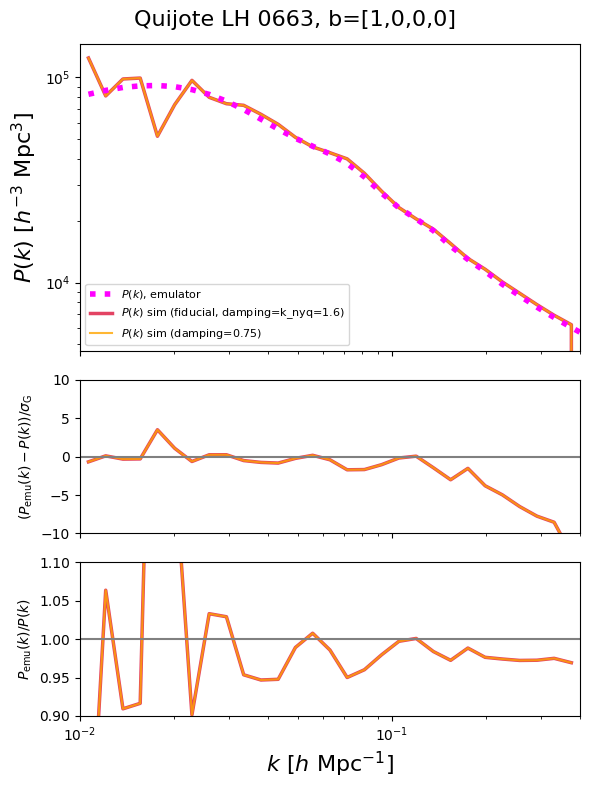

In [ ]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ sim (fiducial, damping=k_nyq=1.6)',
          r'$P(k)$ sim (damping=0.75)',
          r'$P(k)$ sim (damping=0.75, n=1024)',
          ]
colors = ['crimson', 'orange', 'purple', 
          'crimson', 'orange', #'purple', 
          'orange']
lss = ['-', '--',
       ':', '--']
lws = [2.5, 1.5,
       2.5, 1.5]
pk_objs = [pk_obj_sim,
           pk_obj_damp075,
           pk_obj_sim_damp075_n1024
           ]
#zorders = list(range(len(pk_objs),0,-1))
zorders = list(range(len(pk_objs)))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Quijote LH {idx_LH_str}{title_tag}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

# check damping scale effect

In [13]:
box_size = 1000.
n_grid = 512
seed = 0
FixedInitialAmplitude = False
interlacing = False
cosmo = utils.get_cosmo(utils.cosmo_dict_quijote)

In [14]:
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=1, LPT_order=1, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-07-23 16:03:32,072 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-07-23 16:03:32,073 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-07-23 16:03:32,073 bacco.sims : Initialising simulation Default
2024-07-23 16:03:32,073 bacco.sims : ...done in 0.000737 s


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-07-23 16:04:03,692 bacco.scaler : Adding displacement field with a vel-factor=52.941596


bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.941596 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [15]:
norm = n_grid**3
dens_lin = sim.linear_field[0]*norm

2024-07-23 16:04:12,051 bacco.sims : Generating linear field: Di=1.0


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


In [36]:
damping_scale = 0.7 
print("Setting up bias model")
bmodel = bacco.BiasModel(sim=sim, #linear_delta=dens_lin, 
                         ngrid=n_grid, ngrid1=None, 
                            sdm=False, mode="dm",
                            npart_for_fake_sim=n_grid, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )


2024-07-23 16:30:38,741 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [37]:
bias_fields = bmodel.bias_terms_lag()

2024-07-23 16:30:42,800 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-07-23 16:30:42,801 bacco.BiasModel : fttw plan
2024-07-23 16:30:42,802 bacco.BiasModel : Computing linear field ...
2024-07-23 16:30:42,803 bacco.BiasModel : Memory used: 47.05447936 Gigabytes


linear field, damping_scale: 0.7
lindelt none
cold true
bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-07-23 16:31:01,782 bacco.BiasModel : fttw freqs
2024-07-23 16:31:01,785 bacco.BiasModel : tidk freqs
2024-07-23 16:31:10,881 bacco.BiasModel : ifft
2024-07-23 16:31:46,107 bacco.BiasModel : Computing laplacian ...
2024-07-23 16:31:46,109 bacco.BiasModel : Memory used: 52.42343424 Gigabytes
2024-07-23 16:31:48,544 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-23 16:31:48,548 bacco.BiasModel : Memory used: 52.960100352 Gigabytes
2024-07-23 16:31:48,938 bacco.BiasModel : Computing delta squared ...
2024-07-23 16:31:48,940 bacco.BiasModel : Memory used: 53.49697536 Gigabytes
2024-07-23 16:31:50,563 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-07-23 16:31:50,564 bacco.BiasModel : Memory used: 54.033850368 Gigabytes


In [40]:
for i in range(len(bias_fields)):
    print(bias_fields[i][0,0,:5])

[1. 1. 1. 1. 1.]
[ 0.00949985  0.20941865 -0.7327224  -2.1369038  -3.0193505 ]
[-2.6244786 -2.5807128 -2.0876868  1.9417887  6.491909 ]
[ 0.9977337   2.2754383   1.4185985   0.09292197 -0.69866073]
[-0.31430537 -0.44554955 -0.16621415  0.2571907   0.49283218]


In [38]:
damping_scale_d1 = 0.1
print("Setting up bias model")
bmodel_d1 = bacco.BiasModel(sim=sim, #linear_delta=dens_lin, 
                            ngrid=n_grid, ngrid1=None, 
                            sdm=False, mode="dm",
                            npart_for_fake_sim=n_grid, damping_scale=damping_scale_d1, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )


2024-07-23 16:32:16,648 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [39]:
bias_fields_d1 = bmodel_d1.bias_terms_lag()

2024-07-23 16:32:21,517 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-07-23 16:32:21,517 bacco.BiasModel : fttw plan
2024-07-23 16:32:21,518 bacco.BiasModel : Computing linear field ...
2024-07-23 16:32:21,519 bacco.BiasModel : Memory used: 44.907073536 Gigabytes


linear field, damping_scale: 0.1
lindelt none
cold true
bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-07-23 16:32:39,214 bacco.BiasModel : fttw freqs
2024-07-23 16:32:39,215 bacco.BiasModel : tidk freqs
2024-07-23 16:32:48,104 bacco.BiasModel : ifft
2024-07-23 16:33:22,687 bacco.BiasModel : Computing laplacian ...
2024-07-23 16:33:22,693 bacco.BiasModel : Memory used: 50.276102144 Gigabytes
2024-07-23 16:33:25,009 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-23 16:33:25,011 bacco.BiasModel : Memory used: 50.81286656 Gigabytes
2024-07-23 16:33:25,272 bacco.BiasModel : Computing delta squared ...
2024-07-23 16:33:25,273 bacco.BiasModel : Memory used: 51.349635072 Gigabytes
2024-07-23 16:33:26,343 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-07-23 16:33:26,344 bacco.BiasModel : Memory used: 51.886616576 Gigabytes


In [41]:
for i in range(len(bias_fields_d1)):
    print(bias_fields_d1[i][0,0,:5])

[1. 1. 1. 1. 1.]
[-0.66355133 -0.6956566  -0.7227971  -0.74422234 -0.7593206 ]
[0.27675313 0.32039088 0.35888845 0.3903197  0.4130206 ]
[-0.01841045 -0.02442306 -0.03024055 -0.03595193 -0.04161774]
[0.00307669 0.00328874 0.00346613 0.00360256 0.00369357]


now try from lin field, no sim

In [ ]:
damping_scale = 0.7 
print("Setting up bias model")
dens_lin_damped = 
bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin_damped, 
                         ngrid=n_grid, ngrid1=None, 
                            sdm=False, mode="dm",
                            npart_for_fake_sim=n_grid, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )


-14.789997100830078 15.337848663330078
-14.789997100830078 15.337848663330078


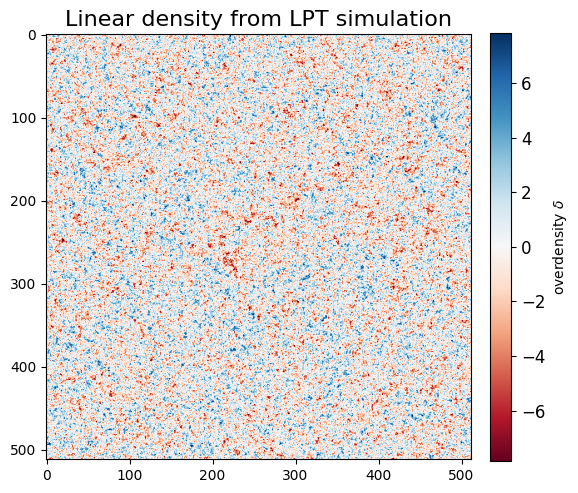

In [48]:
plotter.plot_overdensity_field(dens_lin, title="Linear density from LPT simulation")

-0.9930482 1.0
-0.9930482 1.0


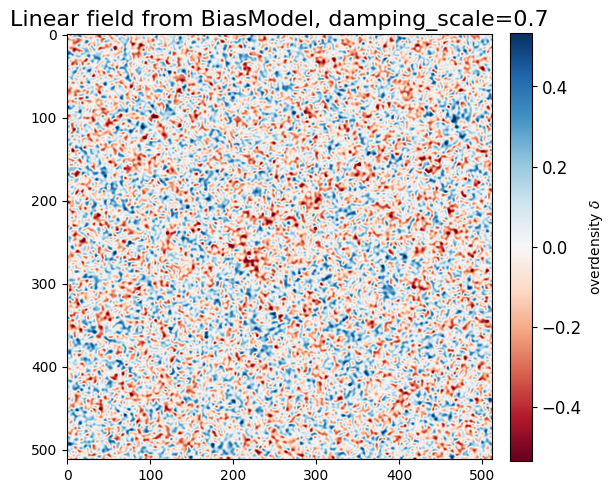

In [50]:
plotter.plot_overdensity_field(bmodel.linear_field, title=f"Linear field from BiasModel, damping_scale={damping_scale}")

-1.8005588 2.0326033
-1.8005588 2.0326033


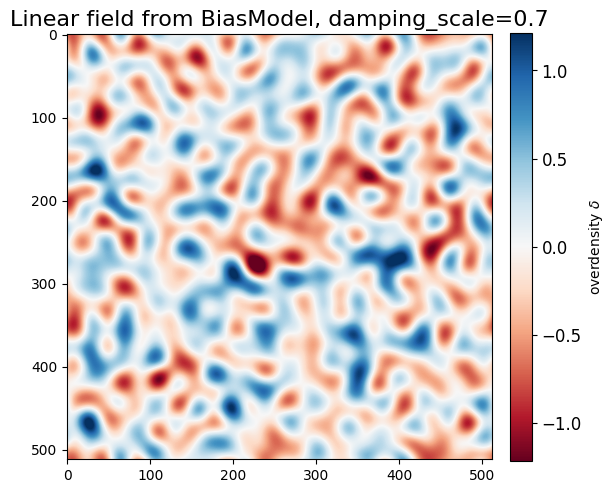

In [51]:
plotter.plot_overdensity_field(bmodel_d1.linear_field, title=f"Linear field from BiasModel, damping_scale={damping_scale}")